# Lecture 1: Introduction to PySpark

Immagine you are interested in working on a large dataset, at the scale of Petabytes:

* Data are distributed in many nodes, collecting all of them in one node would be impossible

* You want to first load data and explore them

* Before moving to machine learning you need to preprocess data

What you would like to do is to run the pre-processing on each node of the cluster where the data is distributed, and return only some high level quantities that will be used in the analysis. 

This is the core concept of Hadoop and Spark: the code goes to the data, rather than the data coming to the machine where the code resides (data locality). 


# Standalone Cluster

For this set of lectures we will work with a standalone cluster deployed on your machine. You can use it to develop and test your application before deploying it on a large cluster.

Youc can choose to:
* **Local cluster**: Create a local cluster by downloading and configuring all components by hand
* **Single Docker container**: Use the provided single Docker image to do the same
* **Docker cluster**: Create the cluster with multiple Docker containers using docker-compose

Run the setup only for the version you are interested and set the following variable.
Note that if you want to use Docker you need to be running this notebook from inside a container, 
following the instructions reported in the README

In [1]:
# set this variable with one of the following values

# -> 'local'
# -> 'docker_container'
# -> 'docker_cluster'

CLUSTER_TYPE ='docker_cluster'

# Local Cluster

<center><img src='imgs/lecture1/standalone_cluster.png'/></center>


### Prerequisites

* Download [spark](https://downloads.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz) 

* Extract the Spark tarball with `tar xvf spark-3.2.1-bin-hadoop3.2.tgz`

* Spark 3 should run on both Java 8/11, so make sure that you have one of them as default (or `JAVA_HOME` environment variable pointing to your java installation)

* If this is set correctly, typing `java --version` on your terminal shoud display something like `openjdk 11.0.15`

### Create a standalone cluster

We will now create a Spark standalone cluster on our local machine. More on this can be found in the [spark documentation](https://spark.apache.org/docs/latest/spark-standalone.html). 

First we need to start the master node.
To do this, move into the spark directory, i.e. `cd spark-3.2.1-bin-hadoop3.2`. 
From here run the following command 
```
./sbin/start-master.sh --host localhost --port 7077 --webui-port 8080
```
This will spin up the Spark master with address `spark://localhost:7077` and a cluster dashboark at `localhost:8080`.

We can now create a worker with 2 cores and 2GB of memory using the following command:

```
./sbin/start-worker.sh spark://localhost:7077 --cores 2 --memory 2g
```

After a few seconds it should appear in the master’s web UI (`localhost:8080` on your browser). 

**Note**: in this configuration there can be at most one worker per each node, i.e. you can't start two workers. 


### Running applications

We can now submit our application to the cluster with commands such as `spark-submit`. For these sessions we will use jupyter-notebooks to explore pyspark interactively. To do this we need one last package wich will set the environment variables needed to get pyspark modules and use the correct version of python. 

The package can be installed via pip running the following cell

In [ ]:
!pip install findspark

We can now initialize all the required variables with `findspark.init()` by passing the path to the spark folder we downloaded previously.

In [ ]:
import findspark

findspark.init('/home/pazzini/work/courses/MAPD_B/MAPD-B/spark/spark-3.2.1-bin-hadoop3.2/')

In [ ]:
# check some of the env variables
!env | grep -i spark

# Single Docker container

If you are opening this notebook using the provided container all environment variables are already set.

It is the possibile to start the Spark master and workers with the following bash commands:

In [ ]:
!$SPARK_HOME/sbin/start-master.sh --host localhost --port 7077 --webui-port 8080

In [ ]:
!$SPARK_HOME/sbin/start-worker.sh spark://localhost:7077 --cores 2 --memory 2g

Now the cluster dashboard is available at `localhost:8080`.

# Docker cluster

If the cluster has been created with Docker compose there is nothing to do. The cluster dashboard can be seen at `localhost:8080` and the master is already available at `spark://spark-master:7077`.

# Spark Session

We can now create the Spark session. 

With the following command we are asking to the master (and resource manager) to create an _application_ with the required resources and configurations. 

In this case we are using all the default options, e.g.  number of core and number of executors, but we can also specify them by hand with `.config("spark.some.config", "value")`. 

The list of available configurations can be found [here](https://spark.apache.org/docs/latest/configuration.html).

In [2]:
from pyspark.sql import SparkSession

# if Spark is run either in Local of Single-Container mode
if CLUSTER_TYPE in ['local', 'docker_container']:
    
    # build a SparkSession 
    #   connect to the master node (address `localhost`) and the port where the master node is listening (7077)
    #   declare the app name 
    #   either connect or create a new context
    spark = SparkSession.builder \
        .master("spark://localhost:7077")\
        .appName("First spark application")\
        .getOrCreate()

# if Spark is run as Docker Container cluster (with docker-compose)
elif CLUSTER_TYPE == 'docker_cluster':
    
    # build a SparkSession 
    #   connect to the master node (address `spark-master`) and the port where the master node is listening (7077)
    #   declare the app name 
    #   configure the executor memory to 512 MB
    #   either connect or create a new context
    spark = SparkSession.builder \
        .master("spark://spark-master:7077")\
        .appName("First spark application")\
        .config("spark.executor.memory", "512m")\
        .getOrCreate()
else:
    print("Variable CLUSTER_TYPE is not set.")


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/01 19:05:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Check the content of the SparkSession `spark` object

In [3]:
spark

Get the SparkContext object from the SparkSession 

The SparkContext is the main entry point for all Spark functionalities, and it is used to work with RDDs

In [4]:
sc = spark.sparkContext
sc

<SparkContext master=spark://spark-master:7077 appName=First spark application>

## Parallelize!

The main feauture of Spark is to distribute data in a number of partitions, either using the memory or the disk available in the executors.

The first command we will use is `parallelize()`. 
This function of the `SparkContext` (`sc`) object is used to create a Resilient Distributed Datasets (**RDD**) from a list collection. 
In other words, it takes a collection and split it amongst the workers. 

We will start with a basic example to get familiar with the main functions of Spark RDDs. 

Starting from a python "dataset" we create an RDD, `dist_data`, and then operate on it in a parallel fashion.

In [5]:
# python dataset
data = [1,2,3,4,5,6,7,8]

# parallelize
dist_data = sc.parallelize(data)

# go check the Spark web UI
#   http://localhost:8080 for the master node web UI
#   http://localhost:4040 for the SparkContext web UI (where you application will reside)


...nothing happend in the Web UI, even though we asked Spark to parallelize our data into a number of partitions! 

That's because `parallelize` is not an action, but a transformation. 
We can trigger it by using the `count` action, a function used to count the number of elements in the RDD. 

In [6]:
# count elements of the rdd
dist_data.count()

8

If you are using two cores, in the WebUI you will see two parallel lines for this task. That's because the RDD consists of two *partitions*. Indeed, under the hood, RDD are stored and represented as partitions, "small blocks" of the original dataset that will be **unit of parallelism**.

<br/><center><img src='imgs/lecture1/rdd_partitions.png'/></center><br />


In other words if we have two cores in our worker, but the RDD is composed of one partitions, then only one task at the time will be run. On the other hand, if the partitions are four only two of them will be processed in parallel.


<br/><center><img src='imgs/lecture1/partitions_processing.png'/></center><br/>

To split our data in an arbitrary number of partitions we can use `numSlices`

In [7]:
# parallelize using a different number of partitions
sc.parallelize(data, numSlices=8).count()

8

In [8]:
sc.parallelize(data, numSlices=8).getNumPartitions()

8

In [9]:
# get the number of partitions
dist_data.getNumPartitions()

4

It's important to visualize that the RDD resides in the worker nodes.
If we print the `dist_data` object we will not see the actual data contained in the RDD, but only that this is a distributed dataset.

This is actually very important, as in a distributed system the datasets we are processing are typically much larger than the availble memory of the driver (it's one of the main reasons we use a distributed system in the first place).
Returning the content of the whole dataset in a single machine is not a clever idea.

However, a distributed dataset can be collected in the driver with `collect()`, i.e. all the workers will send back all the blocks of the RDD. 

This is generally used to collect the end-results, after a computationally heavy processing is first run on the worker nodes. 
This function should be used with caution since it fetches the entire RDD to a single machine and can cause the driver to run out of memory. 

In [10]:
# collect the data_rdd
dist_data.collect()

[1, 2, 3, 4, 5, 6, 7, 8]

## Map and Reduce

We can now write our first map-reduce application. 

The method `map(f)` will apply the function `f` to each _element_ of the RDD. 

In [11]:
# increment each number of the array with map
# and collect the result
dist_data.map(lambda x: x+1).collect()

[2, 3, 4, 5, 6, 7, 8, 9]

Differently from plain Hadoop, in Spark we chain together multiple transformations, without having to strictly follow the Map-then-Reduce pattern.

For instance, we can even run an entire chain of map functions one after the other with no reduce function at all.

In [12]:
# multiple map transformations
# plus collect (action)
dist_data.map(lambda x: x+1)\
         .map(lambda x: x/2)\
         .collect()

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

`reduce` is an action that aggregates all the elements of the RDD using some function and returns the result to the driver. 

We will see later on a version of reduce, `reduceByKey`, wich performs the reduction for elements with the same key. 

Reduce actions can take a function as argument, which will be applied to the elements of the RDD, to perform some kind of aggregation.

For example, we can think about summing the elements of a RDD in pairs with `reduce(lambda x, y: x + y)`.

In [13]:
# increment each number of the dataset (transformation)
# and sum all of them in pairs (action)
dist_data.map(lambda x: x+1).reduce(lambda x, y: x+y)

44

A schematic view of this simple map-reduce application can be seen here:

<br/><center><img src='imgs/lecture1/map_reduce_increment.png'/></center><br/>

## Excercise 1

Write a simple reduce function to find the minimum of `dist_data`.

In [14]:
dist_data.reduce(lambda x, y: min(x,y))

1

In [15]:
dist_data.reduce(min)

1

## Exercise 2 - compute $\pi$

It is possible to estimate $\pi$ by simulating random points in the unit square (side length of $1$) and counting how many fall in the unit circle. The probability of one point falling inside the circle is 

$$
P = \frac{\text{Area circle}}{\text{Area square}} = \frac{\pi}{4}
$$

We can estimate this probabiliy by counting the number of simulated points inside the circle

$$
P = \frac{\text{#Points in circle}}{\text{#Points}} 
$$

Thus obtaining 

$$
\pi \approx 4 \cdot \frac{\text{#Points in circle}}{\text{#Points}}
$$

<br/><center><img src='imgs/lecture1/pi_estimation.png'/></center><br/>

This can be done in Spark running the computation in parallel with the following steps:
1. Create the "dummy RDD" containing placeholders for the points (e.g. use the value 0 as placeholder for each data point)
2. Generate the points as random (x,y) pairs and check if each of them falls inside/outside the circle
3. Count the points inside the circle

Think about which transformations are needed to generate the points and to check if they fall inside the circle.
Combine all the transformations and the action in a single pipeline.

In [16]:
import random

num_points = 100000

## instantiate "placeholder RDD"
points_rdd = sc.parallelize([0]*num_points)

def in_circle(dummy):
    ## simulate the point and check if
    ## it is inside the circle 
    ## return 0 or 1
    x = random.random()
    y = random.random()
    return 1 if x**2 + y**2 < 1 else 0

# count points inside the circle
points_inside = points_rdd.map(lambda x: in_circle(x)).reduce(lambda a, b: a+b)

# print result
print ("pi =", 4*points_inside/num_points)

pi = 3.15


The same result can be achieved using the `filter` transformation. 

`filter(f)` returns a new RDD containing only the element of source RDD on which `f` is `true`.

In [17]:
# perform the same exercise using filter
points_inside = points_rdd \
    .map(lambda x: random.random()**2 + random.random()**2) \
    .filter(lambda x: x < 1) \
    .count()

# # or
# points_inside = points_rdd \
#     .map(lambda x: (random.random(),random.random())) \
#     .filter(lambda p: p[0]**2 + p[1]**2 < 1) \
#     .count()


# print result
print ("pi =", 4*points_inside/num_points)

pi = 3.14852


## Reduce by key and flat map

Consider the following dataset where each element consists of a tuple `(group, value)` (a **key-value pair**). 

This can be for example:
- `group` = product class, and 
- `value` = revenue

In [18]:
class_list = [('group1', 10), ('group2', 4), ('group3', 1), ('group2', 7), ('group1', 8)]
class_rdd = sc.parallelize(class_list)

We could be interested in operating only on the values of the dataset, discarding the keys.

In [19]:
# operate only on the values
class_rdd.map(lambda el: (el[0], el[1]+1)).collect()

[('group1', 11), ('group2', 5), ('group3', 2), ('group2', 8), ('group1', 9)]

The same result can be achieved using `mapValues`

In [20]:
# do the same using map values
class_rdd.mapValues(lambda x: x+1).collect()

[('group1', 11), ('group2', 5), ('group3', 2), ('group2', 8), ('group1', 9)]

We can perform a reduce function for each class using `reduceByKey`: in this way we are applying the reduce function only to the elements of the same class.

Despite its name, `reduceByKey` is not an action, but a transformation, since it returns a distributed dataset (the result of an aggregation by key could still be very large if the number of keys is large).  

In [22]:
# compute the minimum using reduce by key
class_rdd.reduceByKey(lambda x, y: min(x,y)).collect()

[('group1', 8), ('group3', 1), ('group2', 4)]

We can further filter our results by using `takeOrdered` to get the first 2 results ordered by key.

In [23]:
class_rdd.reduceByKey(lambda x, y: min(x,y)) \
    .takeOrdered(2, key=lambda x: -x[1])

[('group1', 8), ('group2', 4)]

If we are not interested in treating the dataset as key-value pairs, or in general we have a non-flat dataset (e.g. each element of the RDD is a list, or another object), we can use `flatMap` to "explode" each element returning a plain sequence of elements.

In [24]:
# flatten the rdd
class_rdd.flatMap(lambda el: el).collect()

['group1', 10, 'group2', 4, 'group3', 1, 'group2', 7, 'group1', 8]

In [25]:
sc.parallelize([[1,2,3], [2,3,4]]) \
    .flatMap(lambda x: x) \
    .collect()

[1, 2, 3, 2, 3, 4]

## Exercise 3: word count

You have received the following message from one of your friend: 

In [26]:
message = [
    'One ring to rule them all, ? one ring to find them,\n',
    'One ring $ to bring them all, and in the % darkness bind them;\n',
    'In the Land of Mordor @ where the shadows lie.'
]

print(''.join(message))

One ring to rule them all, ? one ring to find them,
One ring $ to bring them all, and in the % darkness bind them;
In the Land of Mordor @ where the shadows lie.


You are interested in counting the occurence of each word.

First, you may want to need to clean-up the message (e.g remove symbols such as `@` and `$`).

You also want to change all the words to lower case, to avoid counting the same word twice.

In [27]:
# parallelize the message
message_rdd = sc.parallelize(message)
message_rdd.collect()

['One ring to rule them all, ? one ring to find them,\n',
 'One ring $ to bring them all, and in the % darkness bind them;\n',
 'In the Land of Mordor @ where the shadows lie.']

Hint: use `string.punctuation` or a regular expression to remove the unwanted character

In [28]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
# step 1: create the words_rdd where each element is a word
# eg: ['one', 'ring', 'to', 'rule', 'them']

def clean_row(row):
    # clean the row and return the list of words
    word_list = []
    
    ## Code
    for word in row.strip().split():
        clean_word = ''
        for char in word:
            if char not in string.punctuation:
                clean_word += char
        if clean_word!="":
            word_list.append(clean_word.lower())
    ##
    
    return word_list

# apply transformation
words_rdd = message_rdd.flatMap(clean_row)
words_rdd.collect()[:10]

['one', 'ring', 'to', 'rule', 'them', 'all', 'one', 'ring', 'to', 'find']

In [30]:
# step 2: perform word count!
# -> crate pairs (word, 1)
# -> reduce and count

word_count_rdd = words_rdd.map(lambda word: (word, 1)) \
    .reduceByKey(lambda c1, c2: c1+c2)
word_count_rdd.collect()

[('them', 4),
 ('in', 2),
 ('bind', 1),
 ('of', 1),
 ('where', 1),
 ('shadows', 1),
 ('to', 3),
 ('and', 1),
 ('the', 3),
 ('rule', 1),
 ('mordor', 1),
 ('lie', 1),
 ('bring', 1),
 ('land', 1),
 ('one', 3),
 ('ring', 3),
 ('all', 2),
 ('darkness', 1),
 ('find', 1)]

The method `takeOrdered(n, key)` allows to collect only the first $n$ elements based on the ordering provided by key. Ordering is by default ascending.

In [31]:
# collect the 3 most occurent words
word_count_rdd.takeOrdered(3, key=lambda x: -x[1])

[('them', 4), ('to', 3), ('the', 3)]

## Exercise 4 - Linear regression

The files in `../datasets/lecture1/` contain the measure of a sensor. Each measure is in the form 

```
Measure  N: (t,val)
```

There could be pairs such as `(t, None)`, corresponting to missing values. This measure should be removed. 

We are interested in knowing if there is any sort of relation between `t` and `val`.

The first task consits in reading each file and creating an RDD containing as element the pairs `(t,val)`.

We can first inspect the first lines of a file to get a sense of the data: 

In [32]:
!head ../datasets/lecture1/file_1.txt

Measure  0: (-10.00,0.70)
Measure  1: (-9.95,0.61)
Measure  2: (-9.90,0.47)
Measure  3: (-9.85,None)
Measure  4: (-9.80,0.58)
Measure  5: (-9.75,0.29)
Measure  6: (-9.70,0.35)
Measure  7: (-9.65,0.25)
Measure  8: (-9.60,0.39)
Measure  9: (-9.55,0.52)


Imagine that each file contain millions of measure and there may be hundreds of files. Moreover, data can be already saved in files in multiple nodes. 

For the purpose of this exercise, we will assume that the data is already distributed in the cluster.

For this reasons reading all the files with python, and then using `parallelize` should be avoided at all costs.
This would be a very inefficient way to read the data, as we would have to read all the files in the driver (possibly getting out of memory), then splitting the data in the workers. 

Instead, we can parallelize the _list of files_ and then read them in parallel with Spark. 

In [33]:
if CLUSTER_TYPE=='local':
    base_path = '/home/pazzini/work/courses/MAPD_B/MAPD-B/spark/datasets/lecture1/file_{}.txt'
else:
    base_path = '/opt/workspace/datasets/lecture1/file_{}.txt'
file_list = [base_path.format(i) for i in range(1,5)]

files_rdd = sc.parallelize(file_list)
files_rdd.collect()

['/opt/workspace/datasets/lecture1/file_1.txt',
 '/opt/workspace/datasets/lecture1/file_2.txt',
 '/opt/workspace/datasets/lecture1/file_3.txt',
 '/opt/workspace/datasets/lecture1/file_4.txt']

#### Note
In this case we could have used the function `textFile`, which takes as input the path to the files and read them into an RDD. 

To access a file in with this function we need to prepend `file://` if the file is in the local file system. If the file is in hadoop the path will be similar to `hdfs://namenode.com:8020/path_to_the_file`. In the same way, if the file is stored in `s3` the path will be `s3://`.

The function `textFile` can be used in this case only because files are stored in `.txt` files.
In many cases, however, a custom data loader is required instead.
On the other hand, we should try to use this function as much as possible since they are much more performant than standard python code.  

```python
text_rdd = sc.textFile("file://"+base_path.format('*'))
text_rdd.collect()[:4]
```

However, in this example we will wire a custom data loader. 

Starting from the RDD files, write a map that convert it into an RDD, `data_rdd`, where each element is a tuple `(t, val)`. 

Remember to remove points with `None` as measure. 

The elements of `data_rdd` should finally be something like:

```
[(0.0,9.93), (-1.0,9.02), ...]
```

In order to do this, we can use _regular expressions (or regex)_.

A regular expression is a sequence of characters that allows to identify and select a **pattern** in a string, instead of a specific substring.
Most editors (including Jupyter) allow to use regex to find and replace text based on patterns, and several interesing sites offer a simple interface to learn and experiment with regexp, e.g. https://regex101.com/

All following charachters are considered "meta-characters" in regex

`. ^ $ * + ? { } [ ] \ | ( )`

In a regular expression, all these symbols will be **not** interpreted as their characters, but are used to build up the patterns and search for matches in the text.

The main notable examples are:

`[ ]` square brakets meaning exactly 1 character

| regexp | interpretation |
| --- | --- |
| \[a\] | the letter `a` |
| \[ax\] | the letter `a` or `x` |
| \[a-x\] | any letter from `a` to `x` |
| \[a-zA-F\] | any letter from `a` to `z` and from `A` to `F` |
| \[0-9\] | any number from 0 to 9 |

`^` represents a `not`

| regexp | interpretation |
| --- | --- |
| \[^b02\] | all charachters but `b`,`0`and `2` |

`.` represents any character at all

| regexp | interpretation |
| --- | --- |
| . | all charachters |

`?` makes the preceding character in the regular expression optional

| regexp | interpretation |
| --- | --- |
| colou?r | `color` or `colour` |

`*` match the preceding character (or combination) zero or more times

| regexp | interpretation |
| --- | --- |
| go*gle | `ggle`,`gogle`,`google`,`gooogle`,... |

`\t` matches a tab

`\n` matches a new-line

`^` (outside of `[]`) matches the start of a line

`$` matches the end of a line

Regex can be used in plain Python with the `re` module.

Let's use the `re` module to implement the appropriate regular expression to clean up our data.

We should find all float values possibly starting with a +/- sign and collecting them in pairs.

In [34]:
import re

line_ = 'Measure  0: (.05,0.70)'
float_pattern = '-?[0-9]*\.[0-9]*'
coordinates = re.findall(f'{float_pattern},{float_pattern}', line_)
coordinates   

['.05,0.70']

In [35]:
import re

def parse_file(file):
    
    ## load lines 
    with open(file, 'r') as fin:
        lines = fin.readlines()
        
    points = []
    ## extract points
    for line in lines:
        float_pattern = '-?[0-9]*\.[0-9]*'
        coordinates = re.findall(f'{float_pattern},{float_pattern}', line)
        
        if len(coordinates)!=0:
            coordinates = coordinates[0].split(',')
            points.append(
                (float(coordinates[0]), float(coordinates[1]))
            )
    ## 
    return points

data_rdd = files_rdd.flatMap(lambda file: parse_file(file))
data_rdd.collect()[:10]

[(-10.0, 0.7),
 (-9.95, 0.61),
 (-9.9, 0.47),
 (-9.8, 0.58),
 (-9.75, 0.29),
 (-9.7, 0.35),
 (-9.65, 0.25),
 (-9.6, 0.39),
 (-9.55, 0.52),
 (-9.5, 0.68)]

With `sample(with_replacement, fraction)` we can sample some points from the original RDD. 

This is useful if we want to collect only a fraction of our data.

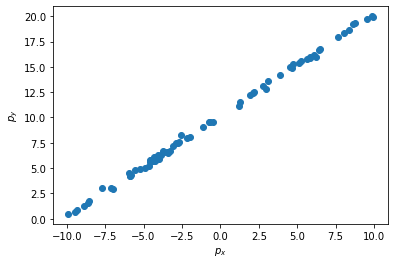

In [36]:
import matplotlib.pyplot as plt 
import numpy as np

# collect a sample
data = np.array(data_rdd.sample(False,0.2).collect())

plt.scatter(data[:,0], data[:,1])

plt.xlabel(r'$p_x$')
plt.ylabel(r'$p_y$')
plt.show()

We will now implement a distributed gradient descent and use it to find the best parameters for a linear model. 

Given an input $X$ the ouput of the model is 

$$
Y = W X = w_{0} + w_1 x_1 + \dots + w_p x_p
$$

In our case, we have $Y=y(w,x)$, $W = [w_0, w_1]$ and $X=[1, x]^T$, in other words

$$
y(w,x) = w_0 + w_1 x
$$

We are interested in estimating the optimal parameters $w^\star$ of the line fitting our data. 

To do this we will use **gradient descent**, an iterative procedure that allows us to find a local minumum of a differentiable function.

In our case, we would like to minimize the square residuals, i.e.

$$
J(W,X) = \frac{1}{2n} \sum_{i=1}^{n} [Y(W, X)- y_i]^2 = \frac{1}{2n} \sum_{i=1}^{n} [ (w_0 +w_1x) - y_i]^2
$$

where $y_i$ is the true value. 

In each step of the gradient descent we use the following update rule

$$
W_{i+1} = W_i - \gamma \nabla J_W(W_i, X)
$$

where $\gamma$ is the learning rate, a variable used to reduce the size of each step.


In other word we are moving in the opposite direction of the gradient, i.e. towards the minimum of the function. 

Recalling that $W=[w_0, w_1]$ and $X=[1,x]$ we have that each component of the gradient, i.e. $\frac{\partial}{\partial w_p} J(W,X) $

$$
\nabla J(W, X) = \left[\frac{1}{n} \sum_{i=1}^{n} [Y(W,X)- y_i]\cdot1, \frac{1}{n} \sum_{i=1}^{n} [Y(W,X)- y_i]\cdot x_i \right]
$$

We can now write a map-reduce job used to estimate the parameters using gradient descent on the full dataset.

We start by defining the weights vector and initializing it to some values, e.g. $(10, 0.5)$ is a good guess :)

In [37]:
# use numpy to create the W weight array

import numpy as np

W = np.array([10, 0.5])

Implement then the functions computing the prediction given as input $x$ and the current weights W

In [38]:
# predict y for any given x and weights W
def predict(x, W):
    # return prediction
    return W[0] + W[1]*x
    

# test the function in local 
assert predict(1, [10,1]) == 11

Implement the function computing the gradient for one example, given as inputs:
1. the point $P=(x,y)$, and 
2. the current set of weights $W$. 

Remember that the gradient has two components, one per parameter. 

Furthermore, the normalization $\frac{1}{n}$ can be ommited since we can apply it afterwards, having summed the gradients of all examples.

In [39]:
# compute the gradient 
def gradient(P, W):
    # return the prediction given the x value of P and the weights W
    pred = predict(P[0], W)
    
    # compute gradient
    gradient = np.dot(pred-P[1], [1,P[0]])
    return gradient

# test the function in local
assert not (gradient((1,11), [10,1])).all() 

We are now ready to implement the gradient descent and find the optimal line parameters. 

**Hint**: compute the gradient for each point in parallel, and them sum all of them. Finally, use this sum to update the weights vector. 

In [40]:
# count points based on the partitioned data
num_points = data_rdd.count()

# re-declare the weight vector here: 
#   this is useful if the cell is run multiple times
W = np.array([10,0.5])

# define the learning rate
lr = 0.01

# define the number of iterations
num_it = 20

for i in range(num_it):
    # run the gradient descent in parallel and then sum the gradients 
    grad = data_rdd.map(lambda P: gradient(P,W)).reduce(lambda g1,g2: g1+g2)
    # update the weights according to the learning rate and the gradient
    W = W - (lr/num_points)*grad
    
print("Final parameters: x0={:.2f}, x1={:.2f}".format(W[0], W[1]))

Final parameters: x0=10.03, x1=1.00


Check out the results by plotting the data points and the resulting best fit line.

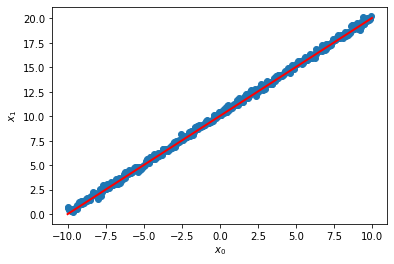

In [41]:
import matplotlib.pyplot as plt

data = np.array(data_rdd.collect())

plt.scatter(data[:,0], data[:,1])

x = np.arange(-10,11)
y = W[0] + W[1]*x

plt.plot(x, y, color='red', lw=2)

plt.xlabel(r'$x_{0}$')
plt.ylabel(r'$x_{1}$')

plt.show()

## Caching

From the WebUI we can see that in each iteration Spark is computing every operation from the very beginning, i.e. **the parallelization of the text files!**. 
This is not really necessary, as this first operation will not need to be re-executed every step.

With `persist()` we can tell spark to cache the intermediate results, e.g. after the function parsing the files, into the executors' memory. 

In this way the same dataset will be loaded in the next iterations much faster, at the cost of having the dataset stored in memory. 

**Note:** to be precise, there could be different levels of [persistence](https://spark.apache.org/docs/latest/rdd-programming-guide.html#rdd-persistence) of data into the executors' memory.

The RDD can be "unpersisted" with `unpersist()`, freeing up memory when needed.

Performe the gradient descent iterations again by caching `data_rdd` ad look at the WebUI.

In [42]:
# persist the original RDD
data_rdd = data_rdd.persist()

# --- same code as previously ---
num_points = data_rdd.count()

W = np.array([10,0.5])

lr = 0.01

num_it = 20

for i in range(num_it):
    grad = data_rdd.map(lambda P: gradient(P,W)).reduce(lambda g1,g2: g1+g2)
    W = W - (lr/num_points)*grad

print("Final parameters: x0={:.2f}, x1={:.2f}".format(W[0], W[1]))

Final parameters: x0=10.03, x1=1.00


In [43]:
# free up the memory
data_rdd = data_rdd.unpersist()

## Residuals

Compute the residuals using Spark, and plot it in a histogram. 

The residual of the point $(x_i, y_i)$ with respect to the model $y(x)$ is simply defined as

$$
R_i = y(x_i) - y_i
$$

In [44]:
residuals_rdd = data_rdd.map(lambda x: predict(x[0], W) - x[1])

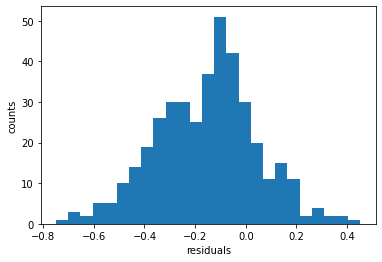

In [45]:
plt.hist(residuals_rdd.collect(), bins=25)
plt.xlabel("residuals")
plt.ylabel("counts")
plt.show()

# Stop worker and master

In [46]:
# stop the running Spark context
sc.stop()

In [47]:
# stop the running Spark session
spark.stop()

### Stop Spark services - Local cluster

To stop the Spark execution in the master and worker nodes, issue the following bash commands

In [ ]:
!$SPARK_HOME/sbin/stop-worker.sh

In [ ]:
!$SPARK_HOME/sbin/stop-master.sh

### Stop Spark services - Docker container(s)

For the single Docker container, it is sufficient to stop and close the running container.

For the Docker cluster, use `docker-compose down` to stop and clear all running containers.